In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data_training = pd.read_csv('HW2_training.csv')
data_testing = pd.read_csv('HW2_testing.csv')
#data_training = np.array(data_training)
#data_testing = np.array(data_testing)

# Part I Data

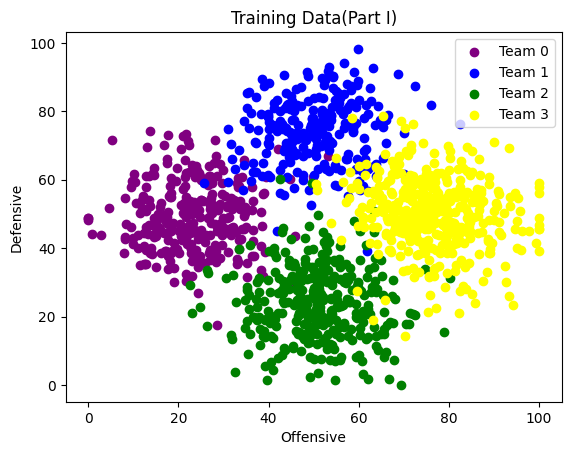

In [132]:
class_colors = {0: "purple", 1: "blue", 2: "green", 3: "yellow"}
plt.figure(1)
M = 4
for i in range(M):
    plt.scatter(data_training[data_training["Team"] == i]["Offensive"], data_training[data_training["Team"] == i]["Defensive"], color=class_colors[i], label=f"Team {i}")
plt.legend(loc = "upper right")
plt.xlabel("Offensive")
plt.ylabel("Defensive")
plt.title("Training Data(Part I)")
plt.show()

## Generative Model

In [133]:
class Generative:
    def __init__(self, data_training , Team_num , M):
        self.data_training = data_training
        self.team_num = Team_num
        self.total_num = np.sum(Team_num)
        self.M = M
    def get_w_w0(self):
        cov_matrix = np.zeros((self.M,2,2))
        mean_vec = np.zeros((self.M,2,))
        cov = np.zeros((2,2))
        for i in range(self.M):   
            data = np.array(self.data_training[self.data_training["Team"] == i][["Offensive", "Defensive"]].T)
            cov_matrix[i] = np.cov(data ,rowvar=True)
            mean_vec[i] = np.mean(data ,axis = 1)
            cov += self.team_num[i] * cov_matrix[i] / self.total_num
        w = np.array([np.linalg.inv(cov) @ mean_vec[i] for i in range(self.M)])
        w0 = np.array([-0.5*mean_vec[i].T @ np.linalg.inv(cov) @ mean_vec[i] + np.log(self.team_num[i] / self.total_num) for i in range(self.M)])
        return w,w0
    def get_test(self,x,w,w0):
        a = np.array([w[i].T @ x + w0[i] for i in range (self.M)])
        p = np.array([np.exp(a[i])/np.sum(np.exp(a)) for i in range(self.M)])
        return p
    def ACC_Confuse(self,x,w,w0,N):
        #T = np.zeros(4)
        T = np.zeros((self.M,self.M))
        y = np.array([self.get_test(np.array([x[i][1],x[i][2]]),w,w0) for i in range(N)])
        result = np.array([np.argmax(y[i]) for i in range(N)])
        for i in range(N):
            T[int(x[i][0])][result[i]]+=1
        A = 0
        for i in range(self.M):
            A+=T[i][i]
        ACC = A / np.sum(T)
        return T,ACC


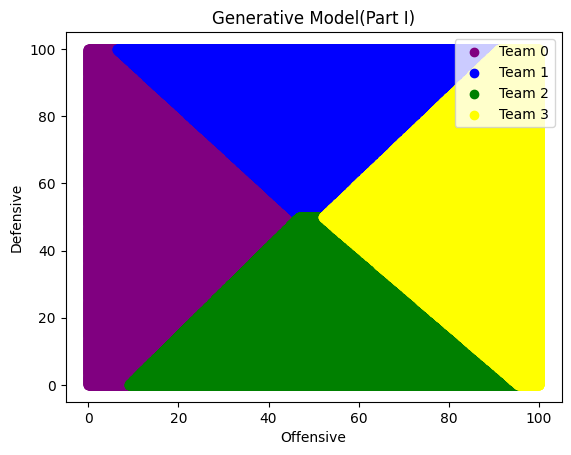

In [134]:
training_class_num = np.array([300, 250, 350,400])
M = 4
gener = Generative(data_training , training_class_num , M)
w,w0 = gener.get_w_w0()


num = 1000
x1 = np.linspace(0, 100, num)
x2 = np.linspace(0, 100, num)
x = np.array([(i,j) for j in x1 for i in x2])
x = x.reshape((num,num,2))
y = np.array([[gener.get_test(x[i][j],w,w0) for j in range(num)] for i in range(num)])
result = np.array([[np.argmax(y[i][j]) for j in range(num)] for i in range(num)])

plt.figure(0)
for i in range(M):
    plt.scatter(x[result == i][:, 0], x[result == i][:, 1], color=class_colors[i], label=f"Team {i}")
plt.legend(loc = "upper right")
plt.xlabel("Offensive")
plt.ylabel("Defensive")
plt.title("Generative Model(Part I)")
plt.show()



# ACC and Confusing Matrix

In [135]:
Confuse_train,ACC_train = gener.ACC_Confuse(np.array(data_training),w,w0,1300)
print(f"Training Data(Generative Model Part I) ACC:",ACC_train)
print(f"Training Data(Generative Model Part I) Confusing Matrix:\n",Confuse_train)

Confuse_test,ACC_test = gener.ACC_Confuse(np.array(data_testing),w,w0,750)
print(f"Testing Data(Generative Model Part I) ACC:",ACC_test)
print(f"Testing Data(Generative Model Part I) Confusing Matrix:\n",Confuse_test)

Training Data(Generative Model Part I) ACC: 0.943076923076923
Training Data(Generative Model Part I) Confusing Matrix:
 [[287.   6.   7.   0.]
 [  9. 229.   0.  12.]
 [ 10.   2. 329.   9.]
 [  0.  12.   7. 381.]]
Testing Data(Generative Model Part I) ACC: 0.912
Testing Data(Generative Model Part I) Confusing Matrix:
 [[187.  10.   3.   0.]
 [  6. 271.   1.  22.]
 [  8.   0. 135.   7.]
 [  0.   3.   6.  91.]]


# Discriminative Model

In [136]:
class discriminative:
    def __init__(self, data_training , Team_num, M , basis_num):
        self.data_training = np.array(data_training)
        self.team_num = Team_num
        self.total_num = np.sum(Team_num)
        self.M = M
        self.basis_num = basis_num
    def get_y(self,x,w,k):
        a = np.array([w[i*self.basis_num:i*self.basis_num+self.basis_num].T @ np.array([1,x[1],x[2]]) for i in range (self.M)])
        #a = np.array([w[i*self.basis_num:i*self.basis_num+self.basis_num].T @ np.array([1,x[1],x[2],x[1]*x[1],x[2]*x[2]]) for i in range (self.M)])
        a = a - np.max(a)
        y = np.exp(a[k])/np.sum(np.exp(a))
        return y
    def gradient(self,w):
        grad = np.zeros(0)
        for i in range(self.M):
            partial = np.zeros(self.basis_num)  # Initialize partial inside the loop
            for j in range(self.total_num):
                y = self.get_y(self.data_training[j], w, i)
                t = self.data_training[j][0] == i
                partial += (y - t) * np.array([1,self.data_training[j][1],self.data_training[j][2]])
                #partial += (y - t) * np.array([1,self.data_training[j][1],self.data_training[j][2],self.data_training[j][1]*self.data_training[j][1],self.data_training[j][2]*self.data_training[j][2]])
            grad = np.append(grad, partial)
        return grad
    
    def gradi_gradi(self,w):
        grad = np.zeros([])
        for k in range(self.M):
            stacked_array = np.zeros([])
            for j in range(self.M):
                partial = np.zeros((self.basis_num,self.basis_num))
                for i in range(self.total_num):
                    yk= self.get_y(self.data_training[i], w, k)
                    yj= self.get_y(self.data_training[i], w, j)
                    phi = np.array([1,self.data_training[i][1],self.data_training[i][2]])
                    #phi = np.array([1,self.data_training[i][1],self.data_training[i][2],self.data_training[i][1]*self.data_training[i][1],self.data_training[i][2]*self.data_training[i][2]])
                    phi = phi.reshape(self.basis_num,1)
                    partial += yk * ((k==j) - yj) * phi @ phi.T
                if j == 0 :
                    stacked_array = partial
                else :
                    stacked_array = np.hstack((stacked_array, partial))
            if k == 0 :
                grad = stacked_array
            else :
                grad = np.vstack((grad, stacked_array))
        #print(grad)
        return grad
    
    def iteration(self):
        w = np.zeros(self.basis_num*self.M)
        ita = 1e-6
        error = self.error(w)
        for i in range(20000):
            gradi = self.gradient(w)
            w -= ita * gradi
            print(f"error: {error} iter: {i}")
            error_new = self.error(w)
            if abs(error - error_new) < abs(error)*0.000001:
                print("finish gradien descent")
                break
            error = error_new
        return w
    def error(self,w):
        error = 0.0
        for i in range(self.total_num):
            error -= self.get_y(self.data_training[i],w,int(self.data_training[i][0]))
        return error
    def newton(self):
        w = np.zeros(self.basis_num*self.M)
        error = self.error(w)
        while 1:
            gradi = self.gradient(w)
            gradi_gradi = self.gradi_gradi(w)
            w -= np.linalg.pinv(gradi_gradi) @ gradi
            error_new = self.error(w)
            if abs(error - error_new) < abs(error)*0.0001:
                print("finish NR")
                break
            error = error_new
        return w

    def get_test(self,x,w):
        a = np.array([w[i*self.basis_num:i*self.basis_num+self.basis_num] @ np.array([1,x[0],x[1]])  for i in range (self.M)])
        #a = np.array([w[i*self.basis_num:i*self.basis_num+self.basis_num] @ np.array([1,x[0],x[1],x[0]*x[0],x[1]*x[1]])  for i in range (self.M)])
        a = a - np.max(a)
        p = np.array([np.exp(a[i])/np.sum(np.exp(a)) for i in range(self.M)])
        return p
    
    def ACC_Confuse(self,x,w,N):
        #T = np.zeros(4)
        T = np.zeros((self.M,self.M))
        y = np.array([self.get_test(np.array([x[i][1],x[i][2]]),w) for i in range(N)])
        result = np.array([np.argmax(y[i]) for i in range(N)])
        for i in range(N):
            T[int(x[i][0])][result[i]]+=1
        A = 0
        for i in range(self.M):
            A+=T[i][i]
        ACC = A / np.sum(T)
        return T,ACC
    

finish NR


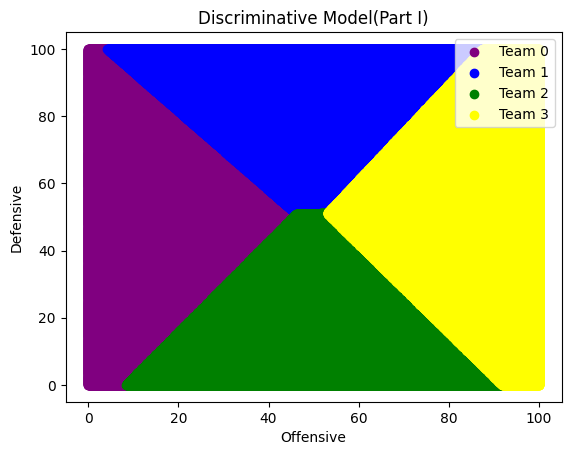

In [137]:
training_class_num = np.array([300, 250, 350,400])
M = 4
discri = discriminative(data_training , training_class_num , M , 3)
#w = discri.iteration()
w = discri.newton()
num = 1000
x1 = np.linspace(0, 100, num)
x2 = np.linspace(0, 100, num)
x = np.array([(i,j) for j in x1 for i in x2])
x = x.reshape((num,num,2))
y = np.array([[discri.get_test(x[i][j],w) for j in range(num)] for i in range(num)])
result = np.array([[np.argmax(y[i][j]) for j in range(num)] for i in range(num)])

plt.figure(0)
for i in [0,1,2,3]:
    plt.scatter(x[result == i][:, 0], x[result == i][:, 1], color=class_colors[i], label=f"Team {i}")
plt.legend(loc = "upper right")
plt.xlabel("Offensive")
plt.ylabel("Defensive")
plt.title("Discriminative Model(Part I)")
plt.show()


# ACC and Confusing Matrix

In [138]:
Confuse_train,ACC_train = discri.ACC_Confuse(np.array(data_training),w,1300)
print(f"Training Data(Discriminative Part I) ACC:",ACC_train)
print(f"Training Data(Discriminative Part I) Confusing Matrix:\n",Confuse_train)

Confuse_test,ACC_test = discri.ACC_Confuse(np.array(data_testing),w,750)
print(f"Testing Data(Discriminative Part I) ACC:",ACC_test)
print(f"Testing Data(Discriminative Part I) Confusing Matrix:\n",Confuse_test)

Training Data(Discriminative Part I) ACC: 0.9423076923076923
Training Data(Discriminative Part I) Confusing Matrix:
 [[285.   6.   9.   0.]
 [  9. 226.   1.  14.]
 [  9.   2. 331.   8.]
 [  0.  10.   7. 383.]]
Testing Data(Discriminative Part I) ACC: 0.9093333333333333
Testing Data(Discriminative Part I) Confusing Matrix:
 [[185.  10.   5.   0.]
 [  6. 267.   1.  26.]
 [  7.   0. 138.   5.]
 [  0.   2.   6.  92.]]


# Part II Data

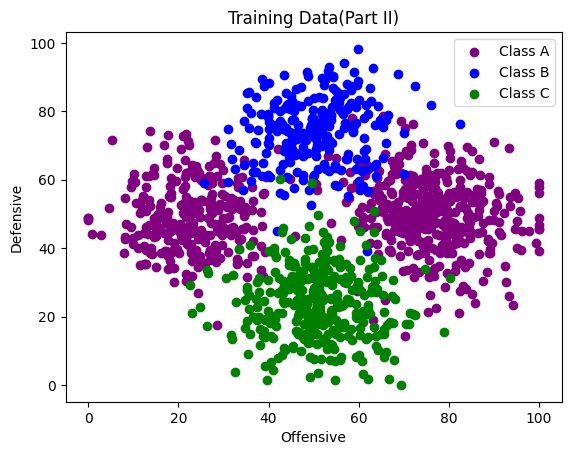

In [139]:
data_training.loc[data_training["Team"] == 3, "Team"] = 0
data_testing.loc[data_testing["Team"] == 3, "Team"] = 0

Type = ["A","B","C"]

M = 3
plt.figure(1)
for i in range(M):
    plt.scatter(data_training[data_training["Team"] == i]["Offensive"], data_training[data_training["Team"] == i]["Defensive"], color=class_colors[i], label=f"Class {Type[i]}")
plt.legend(loc = "upper right")
plt.xlabel("Offensive")
plt.ylabel("Defensive")
plt.title("Training Data(Part II)")
plt.show()

# Part II Generative Model

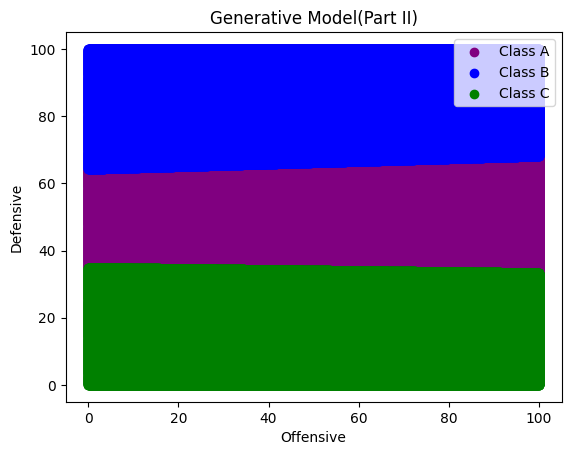

In [140]:
training_class_num = np.array([700, 250, 350])
M = 3
gener_2 = Generative(data_training , training_class_num , M)
w,w0 = gener_2.get_w_w0()


num = 1000
x1 = np.linspace(0, 100, num)
x2 = np.linspace(0, 100, num)
x = np.array([(i,j) for j in x1 for i in x2])
x = x.reshape((num,num,2))
y = np.array([[gener_2.get_test(x[i][j],w,w0) for j in range(num)] for i in range(num)])
result = np.array([[np.argmax(y[i][j]) for j in range(num)] for i in range(num)])


plt.figure(0)
for i in range(M):
    plt.scatter(x[result == i][:, 0], x[result == i][:, 1], color=class_colors[i], label=f"Class {Type[i]}")
plt.legend(loc = "upper right")
plt.xlabel("Offensive")
plt.ylabel("Defensive")
plt.title("Generative Model(Part II)")
plt.show()

# ACC and Confusing Matrix

In [141]:
Confuse_train,ACC_train = gener_2.ACC_Confuse(np.array(data_training),w,w0,1300)
print(f"Training Data(Generative Model Part II) ACC:",ACC_train)
print(f"Training Data(Generative Model Part II) Confusing Matrix:\n",Confuse_train)

Confuse_test,ACC_test = gener_2.ACC_Confuse(np.array(data_testing),w,w0,750)
print(f"Testing Data(Generative Model Part II) ACC:",ACC_test)
print(f"Testing Data(Generative Model Part II) Confusing Matrix:\n",Confuse_test)

Training Data(Generative Model Part II) ACC: 0.8507692307692307
Training Data(Generative Model Part II) Confusing Matrix:
 [[618.  37.  45.]
 [ 54. 196.   0.]
 [ 58.   0. 292.]]
Testing Data(Generative Model Part II) ACC: 0.8413333333333334
Testing Data(Generative Model Part II) Confusing Matrix:
 [[269.  15.  16.]
 [ 58. 242.   0.]
 [ 30.   0. 120.]]


# Part II Discriminative Model

finish NR


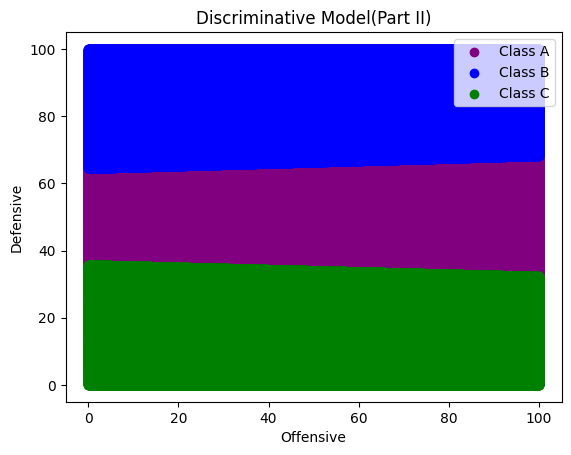

In [142]:
training_class_num = np.array([700, 250, 350])
M =3
discri2 = discriminative(data_training , training_class_num , M , 3)
#w = discri.iteration()
w = discri2.newton()
num = 1000
x1 = np.linspace(0, 100, num)
x2 = np.linspace(0, 100, num)
x = np.array([(i,j) for j in x1 for i in x2])
x = x.reshape((num,num,2))
y = np.array([[discri2.get_test(x[i][j],w) for j in range(num)] for i in range(num)])
result = np.array([[np.argmax(y[i][j]) for j in range(num)] for i in range(num)])

plt.figure(0)
for i in range(M):
    plt.scatter(x[result == i][:, 0], x[result == i][:, 1], color=class_colors[i], label=f"Class {Type[i]}")
plt.legend(loc = "upper right")
plt.xlabel("Offensive")
plt.ylabel("Defensive")
plt.title("Discriminative Model(Part II)")
plt.show()

# ACC and Confusing Matrix

In [143]:
Confuse_train,ACC_train = discri2.ACC_Confuse(np.array(data_training),w,1300)
print(f"Training Data(Discriminative Model Part II) ACC:",ACC_train)
print(f"Training Data(Discriminative Model Part II) Confusing Matrix:\n",Confuse_train)

Confuse_test,ACC_test = discri2.ACC_Confuse(np.array(data_testing),w,750)
print(f"Testing Data(Discriminative Model Part II) ACC:",ACC_test)
print(f"Testing Data(Discriminative Model Part II) Confusing Matrix:\n",Confuse_test)

Training Data(Discriminative Model Part II) ACC: 0.8530769230769231
Training Data(Discriminative Model Part II) Confusing Matrix:
 [[622.  35.  43.]
 [ 54. 196.   0.]
 [ 59.   0. 291.]]
Testing Data(Discriminative Model Part II) ACC: 0.8426666666666667
Testing Data(Discriminative Model Part II) Confusing Matrix:
 [[270.  14.  16.]
 [ 58. 242.   0.]
 [ 30.   0. 120.]]
